# 3D image gradients
***Mar 3 , 2022***

There are many techniques for image gradients calculation, e.g. Sobel, and there may be some libraries out there. Try to implement it yourself and compare it with others

#### _load 3D MRI image data_

In [6]:
import os
import math

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
import scipy, scipy.io
from scipy import ndimage, signal

import h5py

In [7]:
# data file name
fname = '101915_3T_T2w_SPC1'
fnamemix = '105216_3T_T2w_SPC2'
# Load data
with h5py.File(os.path.join('data', fname+'.h5')) as f:
    x = f['data'][()]
    y = f['target'][()]
# print('Shape of x (input, Low Res) =', x.shape) # (128, 128, 32)
# print('Shape of y (target, High Res) =', y.shape) # (256, 256, 64)

In [8]:
def visualise_img(image, fig_size=(4, 8), res=500):
    fig = plt.figure(dpi=res)
    grid = ImageGrid(fig, 111, nrows_ncols=fig_size, axes_pad=0.0)
    for i in range(image.shape[-1]):
        #grid[i].imshow(np.rot90(image[i, ...], 1), cmap='gray') # if rot90 here, the translatory transform direction changed
        grid[i].imshow(image[..., i], cmap='gray')
        grid[i].axis('off')
        grid[i].set_xticks([])
        grid[i].set_yticks([])
    plt.show()

# 3D sobel
## 1. SciPy ndimage sobel
```python
scipy.ndimage.sobel(input, axis=- 1, output=None, mode='reflect', cval=0.0)
```

In [4]:
result = ndimage.sobel(y, axis=0)

In [5]:
print(result.shape)

(256, 256, 64)


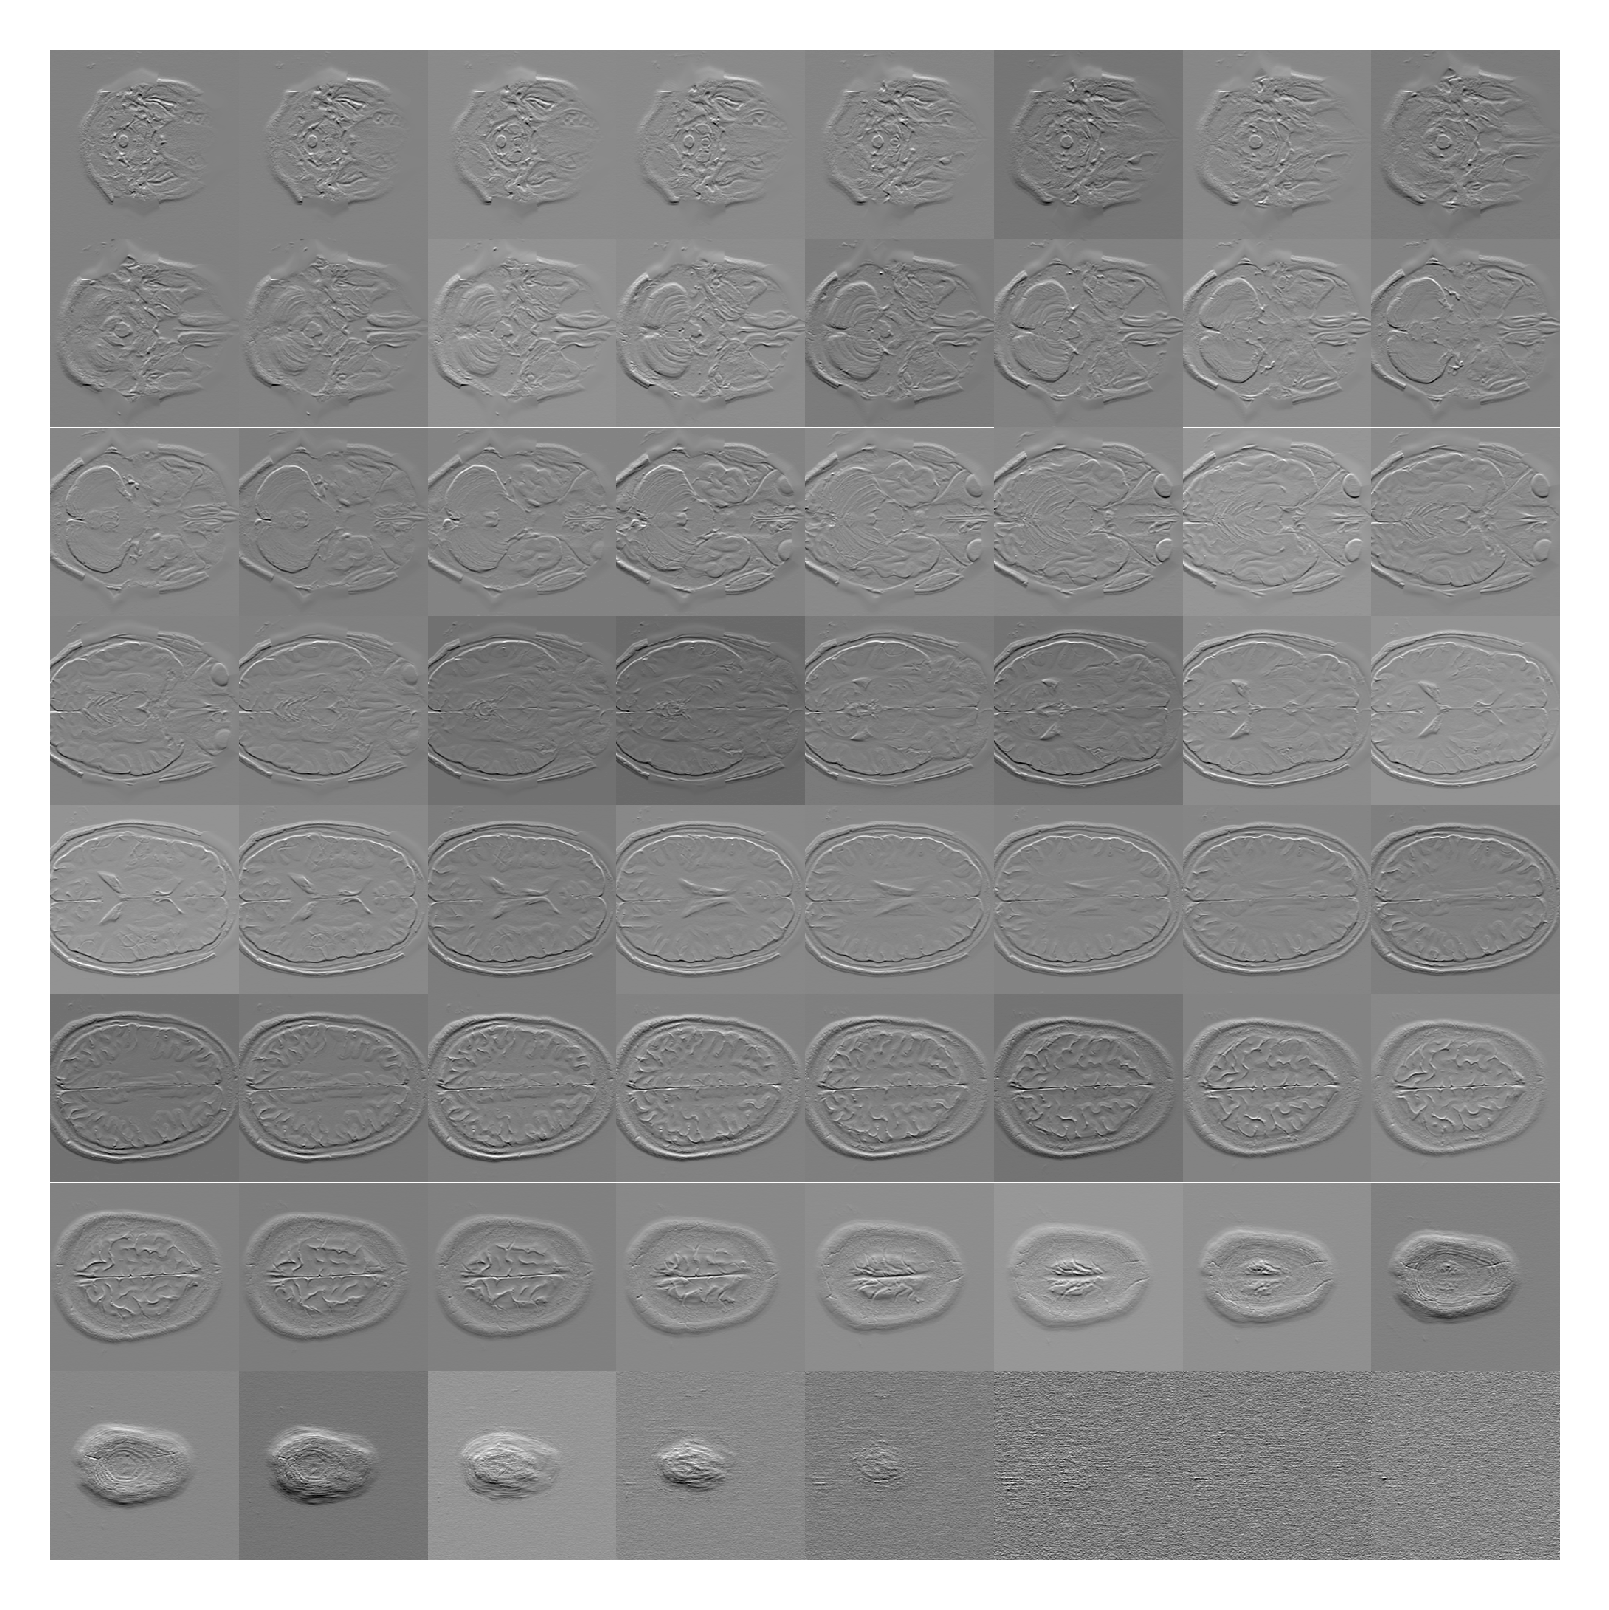

In [6]:
visualise_img(result, (8, 8))

the source code of <code> scipy.ndimage.sobel() </code> :
```python
def sobel(input, axis=-1, output=None, mode="reflect", cval=0.0):
    input = numpy.asarray(input)
    axis = normalize_axis_index(axis, input.ndim)
    output = _ni_support._get_output(output, input)
    modes = _ni_support._normalize_sequence(mode, input.ndim)
    correlate1d(input, [-1, 0, 1], axis, output, modes[axis], cval, 0)
    axes = [ii for ii in range(input.ndim) if ii != axis]
    for ii in axes:
        correlate1d(output, [1, 2, 1], ii, output, modes[ii], cval, 0)
    return output
```
Where the initialization of [<code> output</code>](https://github.com/scipy/scipy/blob/main/scipy/ndimage/_ni_support.py#L73) is :
```python
output = numpy.zeros(shape, dtype=input.dtype.name)
```
The core function of [<code> correlate1d</code>](https://github.com/scipy/scipy/blob/v1.8.0/scipy/ndimage/_filters.py#L83) implementation is written in C with [this wrapper](https://github.com/scipy/scipy/blob/v1.8.0/scipy/ndimage/src/nd_image.c#L184) and [core](https://github.com/scipy/scipy/blob/v1.8.0/scipy/ndimage/src/ni_filters.c#L38). The <code> correlate1d </code> function has a very nice property: the input can be any high dimensional data, but the correlate process will only take place in the given axis; viewing the high dimensional data as slices of 1D data in the given axis.

### Evaluation of Official SciPy implementation
The SciPy implementation of sobel filters are efficient in ways and one of it is that it utilize the *seperable properties* of sobel kernel and can be extended to any *higher dimensional data*. 

At first glance, there seems to be a few limitations: 
- it fixed the size of the kernel to 3 and
- can only choose the coordinal axis direction for gradient calculation. 

However, the larger kernel size of sobel is equivalent to a basic 3*3 sobel plus a large smooth filter (guassian); change the direction of kernel is equivalent to rotation of images, and can be taken care of by other libraries.

The detailed mathematical explanation can be found on [this Answer](https://stackoverflow.com/questions/9567882/sobel-filter-kernel-of-large-size)

### My (seperable) sobel kernel generator

sobel kernel seperable solution with any given size and dimension

*Notice the difference of ndimage.convolve (truncated to the same size as input) and signal.convolve (not truncated, size increased)*

In [52]:
smt = np.array([1,2,1])
size_ = 2
# actualsize = 2*size_+1
dim1 = np.array([-1,0,1])
dim2 = np.array([1,2,1])
if size_ > 1:
    for ii in range(1,size_):
        dim1 = signal.convolve(dim1, smt)
        dim2 = signal.convolve(dim2, smt)

Reference of a useful function: [<code> np.einsum </code>](https://stackoverflow.com/questions/26089893/understanding-numpys-einsum)

In [55]:
kernel2D = np.einsum('i,j->ij', dim1, dim2) # 2D case
kernel3D = np.einsum('a,b,c->abc', dim1, dim2, dim2) # 3D case
kernel4D = np.einsum('a,b,c,d->abcd', dim1, dim2, dim2, dim2) # 4D case
print(kernel3D)

[[[ -1  -4  -6  -4  -1]
  [ -4 -16 -24 -16  -4]
  [ -6 -24 -36 -24  -6]
  [ -4 -16 -24 -16  -4]
  [ -1  -4  -6  -4  -1]]

 [[ -2  -8 -12  -8  -2]
  [ -8 -32 -48 -32  -8]
  [-12 -48 -72 -48 -12]
  [ -8 -32 -48 -32  -8]
  [ -2  -8 -12  -8  -2]]

 [[  0   0   0   0   0]
  [  0   0   0   0   0]
  [  0   0   0   0   0]
  [  0   0   0   0   0]
  [  0   0   0   0   0]]

 [[  2   8  12   8   2]
  [  8  32  48  32   8]
  [ 12  48  72  48  12]
  [  8  32  48  32   8]
  [  2   8  12   8   2]]

 [[  1   4   6   4   1]
  [  4  16  24  16   4]
  [  6  24  36  24   6]
  [  4  16  24  16   4]
  [  1   4   6   4   1]]]


## My implementation using SciPy with adjustable kernel size

Based on SciPy, integrate the above modules:

In [5]:
def mysobel(data, axis=-1, sobelsize=1):
    data = np.asarray(data)
    output = np.zeros(data.shape, dtype=data.dtype.name)

    smt = np.array([1,2,1])
    dim1 = np.array([-1,0,1])
    dim2 = np.array([1,2,1])
    if sobelsize > 1:
        for ii in range(1,sobelsize):
            dim1 = signal.convolve(dim1, smt)
            dim2 = signal.convolve(dim2, smt)
    
    ndimage.correlate1d(data, dim1, axis, output)
    axes = [ii for ii in range(data.ndim) if ii != axis]
    for ii in axes:
        ndimage.correlate1d(output, dim2, ii, output)
    return output

In [9]:
rst = mysobel(y, axis=0, sobelsize=5)

In [10]:
print(rst.shape)

(256, 256, 64)


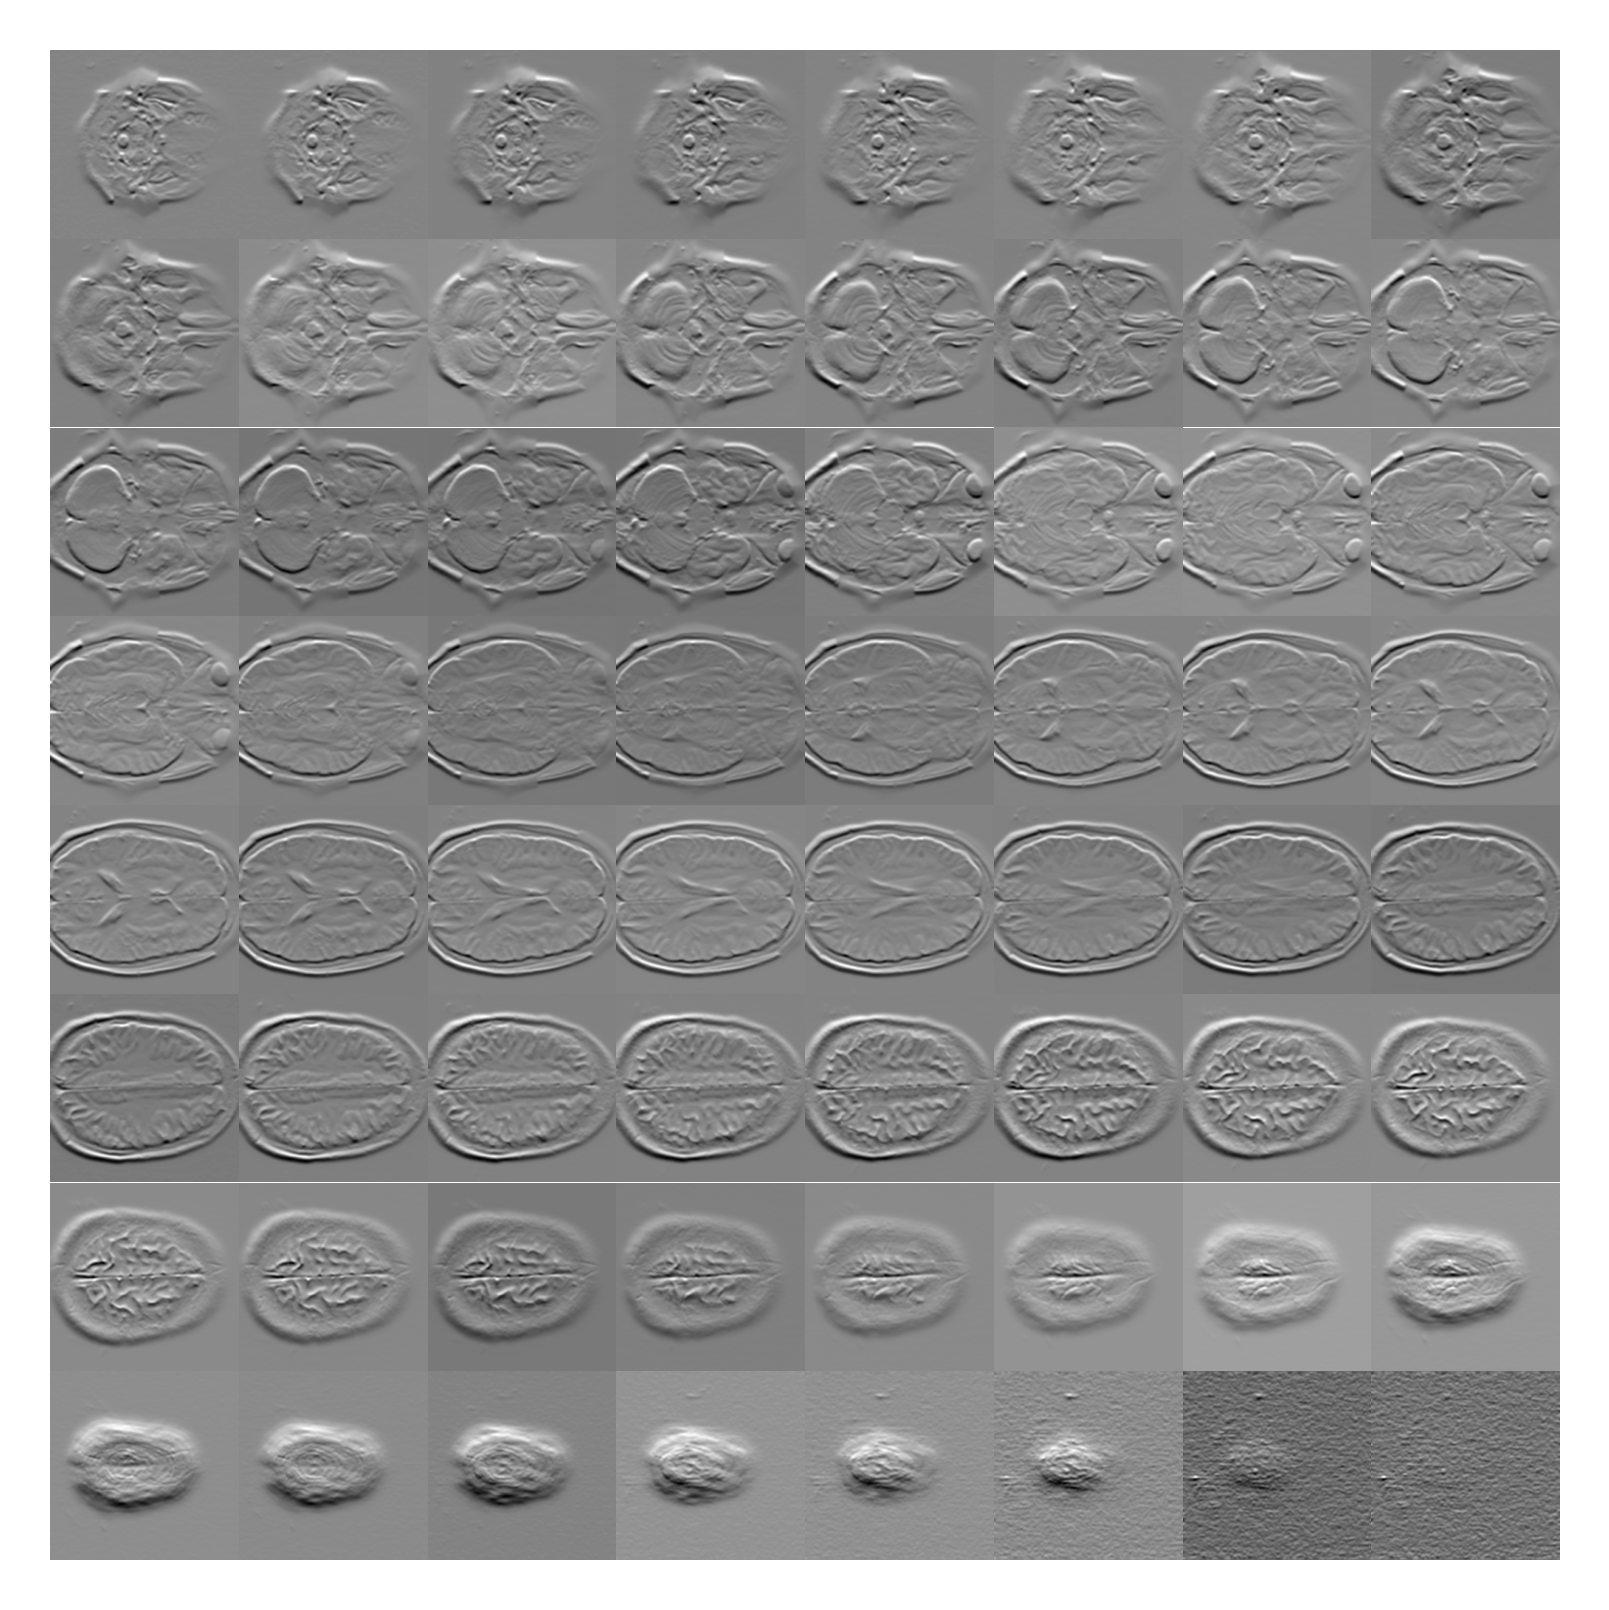

In [12]:
visualise_img(rst, (8,8))

## 2. OpenCV

I have explored the ability of 3D image processing of OpenCV and found it not typically made for data dimensions other than 2. Although it perform perfectly well in 2D case, it is not really elegant to graft it to our 3D data. It does not even have a 1D filter.

Below is an example of 2D case.

In [1]:
import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt

img = cv.imread('seele.png',0)
img = img.astype('float64') # numpy.ndarray

Official <code> cv.sobel</code>

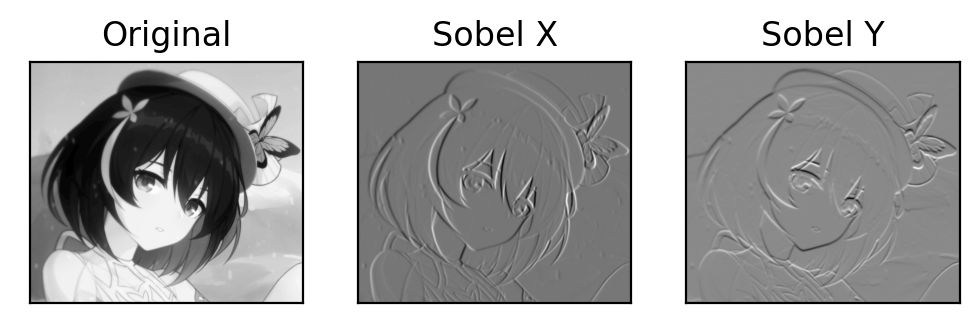

In [4]:
sobelx = cv.Sobel(img,cv.CV_64F,1,0,ksize=5)
sobely = cv.Sobel(img,cv.CV_64F,0,1,ksize=5)
fig = plt.figure(dpi=200)
plt.subplot(1,3,1),plt.imshow(img,cmap = 'gray')
plt.title('Original'), plt.xticks([]), plt.yticks([])
plt.subplot(1,3,2),plt.imshow(sobelx,cmap = 'gray')
plt.title('Sobel X'), plt.xticks([]), plt.yticks([])
plt.subplot(1,3,3),plt.imshow(sobely,cmap = 'gray')
plt.title('Sobel Y'), plt.xticks([]), plt.yticks([])
plt.show()

my own implementation with 2D kernel

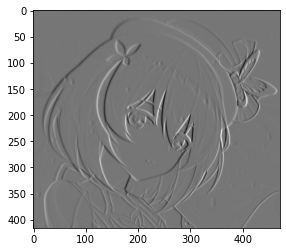

In [3]:
sobelkernel = np.array([[-1.,0.,1.],[-2.,0.,2.],[-1.,0.,1.]])
dstimg = cv.filter2D(img,-1,sobelkernel)
windowname = 'image'
plt.imshow(dstimg, cmap='gray')
plt.show()

## 3. My implementation using PyTorch

Pytorch is not a specialized library for (traditional) image processing and there is no sobel or even filtering function. The <code> torch.nn.Conv1d</code> or <code> torch.nn.Conv2d</code> functions are tailor-made for machine learning and there are lot more utilities than a 'simple' <code> correlate</code> in SciPy, such as the 'grads' and a compulsory input dimension constraint of 3-dimentional(Conv1d) or 4-dimensional(Conv2d) with the extra two being batch and channel. The image gradient based on these shall be neither elegant nor efficient. 

However, it is a fairly nice chance to get familiar with torch utilities. Despite the performance issue, making it work properly as a sobel is the target. 

the following implementation is my pytorch version of the sobel operator, with seperable kernels. (1D + 1D + 1D)

In [7]:
import matplotlib.pyplot as plt

from PIL import Image

import torch
from torch.nn import functional as F
from torchvision import transforms

There are two versions below: 
- first one is only filter the last dimension and permute the data
- second is filter all dimension directly without permuting data
compare the two runtime. Conclusion is that first one is more efficient(suprisingly). Why? yet to find out

In [8]:
class TorchSobel3d(object):

    def __init__(self):
        pass

    def conv1din3d(self, data, weight):
        '''
        data: 3D tensor, float32
        '''
        data = data.unsqueeze(0).unsqueeze(0) # Will this change the original data?
        a,b,h,w,d = data.size() # 1,1,128,128,32

        conv1d = torch.nn.Conv1d(1,1,3)
        with torch.no_grad():
            conv1d.weight.copy_(torch.nn.Parameter(weight))
        temp1 = []
        for ii in range(h):
            tempframe1 = []
            for jj in range(w):
                tempframe1.append(conv1d(data[:,:,ii,jj,:])[0,0]) ## consider using torch.flatten
            tempframe1 = torch.stack(tempframe1)
            temp1.append(tempframe1)
        temp1 = torch.stack(temp1)
        return temp1

    def __call__(self, data, axis=0):
        '''
        rewrite it with no permutation on data but change axis the conv to perform on

        '''
        
        smt = torch.Tensor([1.,2.,1.])
        dif = torch.Tensor([-1.,0.,1.])

        data = data.astype(np.float32)
        data = torch.from_numpy(data)
        data = data.permute(axis-2,axis-1,axis)

        data = self.conv1din3d(data, dif)
        data = data.permute(2,0,1)
        data = self.conv1din3d(data, smt)
        data = data.permute(2,0,1)
        data = self.conv1din3d(data, smt)
        data = data.permute(2,0,1)

        data = data.permute(axis-2,axis-1,axis)
        data = data.permute(axis-2,axis-1,axis)

        return data.detach().numpy()

In [9]:
class TorchSobel3d_2(object):

    def __init__(self):
        pass

    def conv1din3d(self, data, weight, axi=2):
        '''
        data: 3D tensor, float32
        '''
        data = data.unsqueeze(0).unsqueeze(0) # Will this change the original data?
        dim = data.size() # 1,1,128,128,32
        dim = dim[2:5]

        conv1d = torch.nn.Conv1d(1,1,3)
        with torch.no_grad():
            conv1d.weight.copy_(torch.nn.Parameter(weight))
        temp1 = []
        for ii in range(dim[axi-2]):
            tempframe1 = []
            for jj in range(dim[axi-1]):
                if axi == 2:
                    tempframe1.append(conv1d(data[:,:,ii,jj,:])[0,0])
                if axi == 1:
                    tempframe1.append(conv1d(data[:,:,jj,:,ii])[0,0])
                if axi == 0:
                    tempframe1.append(conv1d(data[:,:,:,ii,jj])[0,0])
            tempframe1 = torch.stack(tempframe1)
            temp1.append(tempframe1)
        temp1 = torch.stack(temp1)
        return temp1

    def __call__(self, data, axis=2):
        '''
        rewrite it with no permutation on data but change axis the conv to perform on

        '''
        
        smt = torch.Tensor([1.,2.,1.])
        dif = torch.Tensor([-1.,0.,1.])

        data = data.astype(np.float32)
        data = torch.from_numpy(data)

        #data = self.conv1din3d(data, dif, axi=axis)
        for kk in range(3):
            if kk == axis:
                data = self.conv1din3d(data, dif, axi=axis)
                #continue
            else:
                data = self.conv1din3d(data, smt, axi=kk)

        return data.detach().numpy()

In [10]:
mysobel = TorchSobel3d_2()
myresult2 = mysobel(y, axis=0)

In [11]:
mysobel = TorchSobel3d()
myresult = mysobel(y, axis=0)

In [12]:
print(myresult.shape, myresult2.shape)

(254, 254, 62) (254, 256, 60)


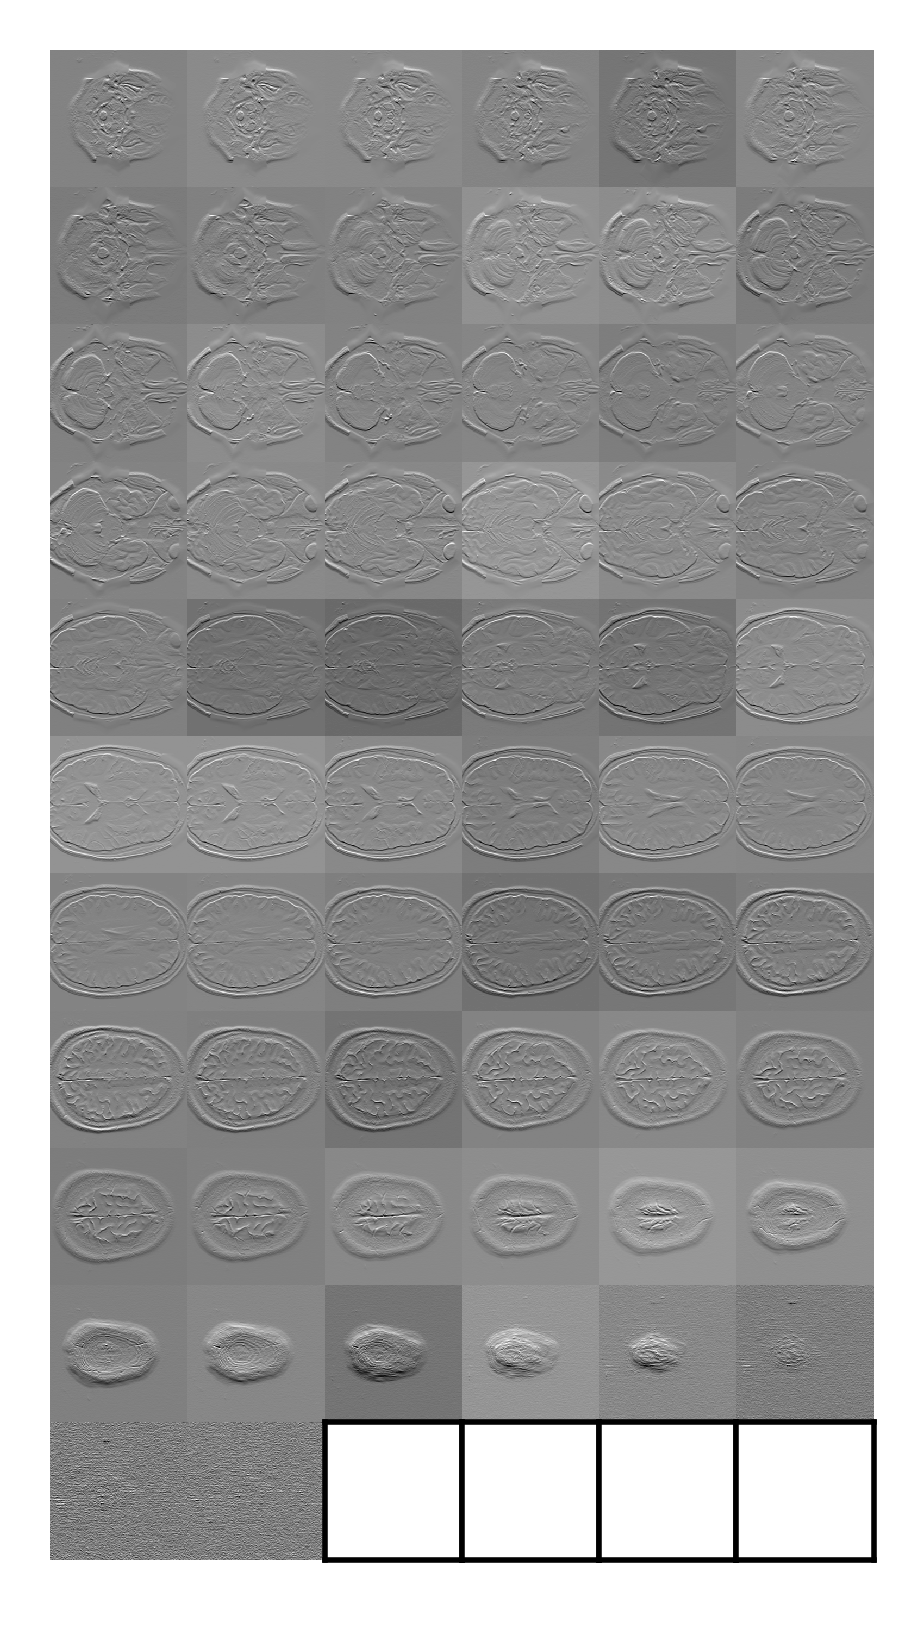

In [13]:
visualise_img(myresult, (11, 6))

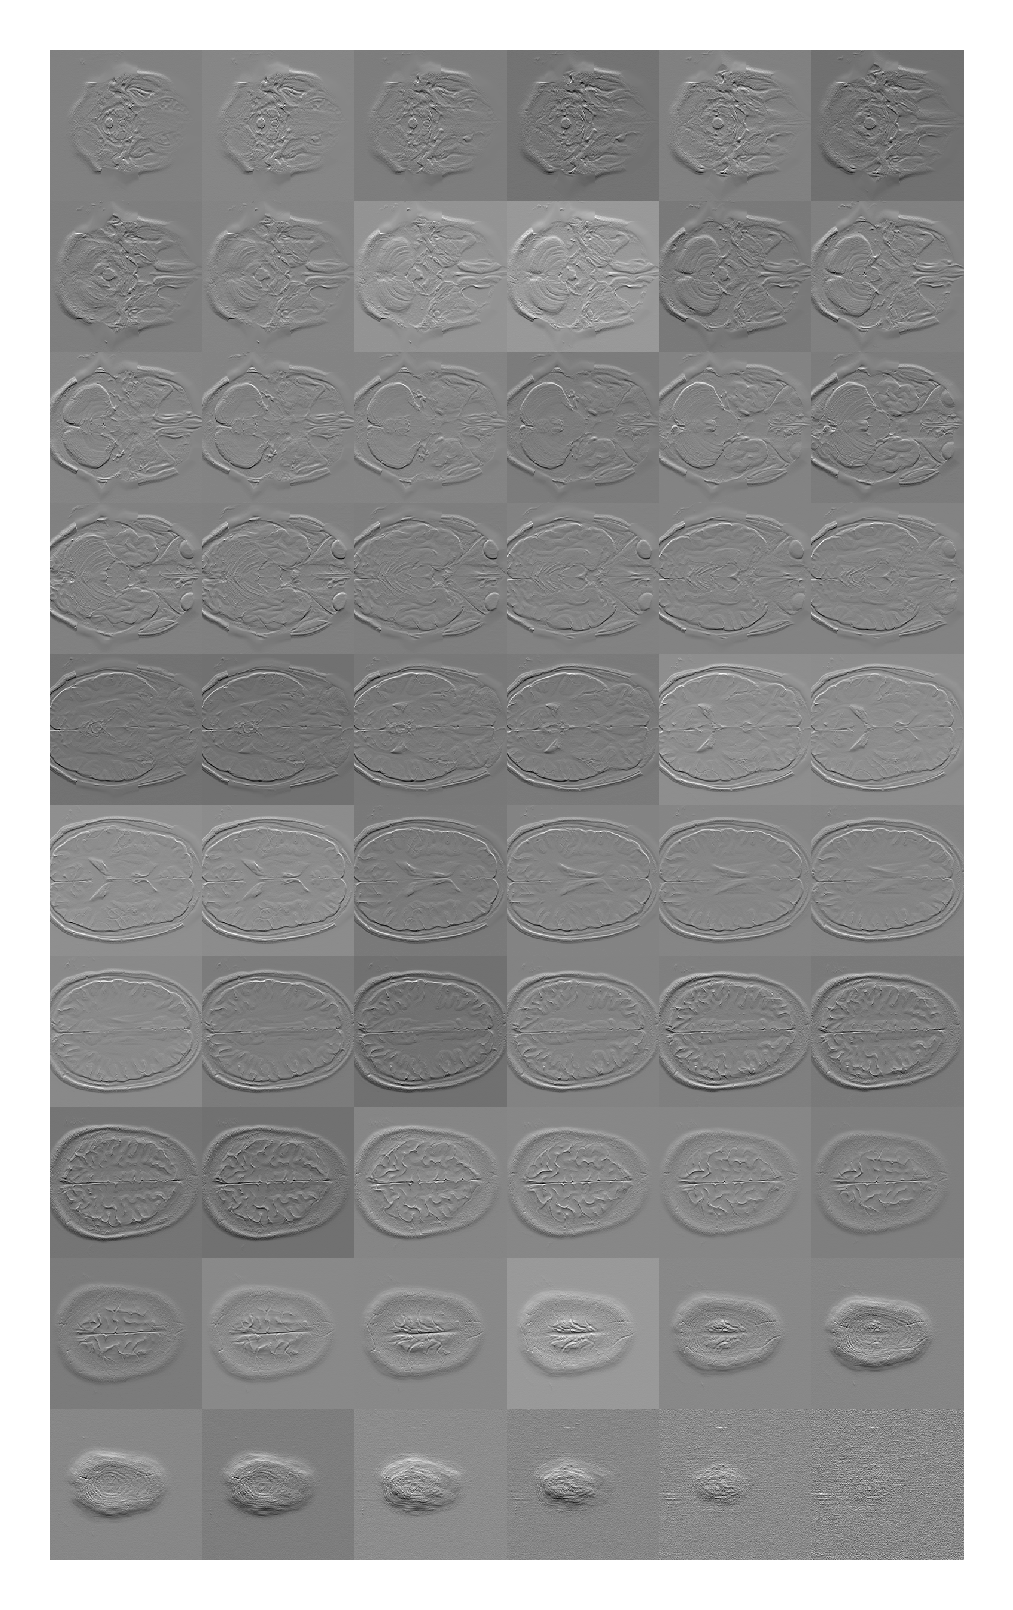

In [14]:
visualise_img(myresult2, (10, 6))